# Cyclic LR for Tiny ImageNet

In [1]:
!pip install imgaug

    100% |████████████████████████████████| 17.3MB 2.5MB/s 
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: numpy 1.14.6
    Uninstalling numpy-1.14.6:
      Successfully uninstalled numpy-1.14.6


In [1]:
!pip install --upgrade scikit-image

    100% |████████████████████████████████| 26.3MB 1.4MB/s 
    100% |████████████████████████████████| 2.0MB 10.6MB/s 
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
  Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1
  Found existing installation: scikit-image 0.13.1
    Uninstalling scikit-image-0.13.1:
      Successfully uninstalled scikit-image-0.13.1


## Download Data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

!cp '/content/gdrive/My Drive/App/Tiny/MyUtils.zip' /content
!unzip -q /content/MyUtils.zip

!cp '/content/gdrive/My Drive/App/Tiny/Mod/tiny-imagenet-200.zip' /content
!unzip -q /content/tiny-imagenet-200.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


## Imports

In [0]:
import keras
import os
import numpy as np
import pandas as pd

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Conv1D
#from keras.layers import Dense
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import SeparableConv2D
from keras.layers import Flatten
from keras.applications import ResNet50

from keras.utils import plot_model

from keras.callbacks import ModelCheckpoint

from keras.optimizers import SGD

In [0]:
## configurations ##
ROOT_DIR='/content'
IMAGE_ROOT_DIR=os.path.join(ROOT_DIR, 'tiny-imagenet-200')

''' 
# utilities.
UTILS_ROOT_DIR='/content'
MY_UTILS_DIR= os.path.join(UTILS_ROOT_DIR,'MyUtils')
SUPPORT_FILES_DIR=os.path.join(MY_UTILS_DIR, 'SupportFiles')
'''

train_data_dir = os.path.join(IMAGE_ROOT_DIR,'train')
validation_data_dir = os.path.join(IMAGE_ROOT_DIR, 'val')
num_train_samples = 100000
num_validation_samples = 10000

## colab crashes, so need to multiple runs - may be 25 epochs three times.
epochs = 5
batch_size = 256

img_height = 64
img_width  = 64
num_channel = 3
num_classes = 200

In [0]:
img_shape = (64,64,3)
num_classes = 200
input = Input(shape=img_shape)

## Build Model

In [5]:
# use pretrained resnet weights - gives features of size 2048
base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=input)


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 1s 0us/step


In [6]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
conv_head = SeparableConv2D(num_classes, (2,2))(base_model.output)
head_model = Flatten()(conv_head)

model = Model(input=base_model.input, output=head_model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("fl...)`
  after removing the cwd from sys.path.


In [15]:
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Compile

In [0]:
model.compile(SGD(), loss='categorical_crossentropy', metrics=['accuracy'])

## Cyclic LR

In [0]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [0]:
clr = CyclicLR(base_lr=0.0001, max_lr=0.001,
                                step_size=800., mode='triangular')

In [0]:
lr_callback_list = [clr]

## Training

In [23]:
train_datagen = ImageDataGenerator()

## train generator
train_generator = train_datagen.flow_from_directory(
                    train_data_dir,
                    target_size=(img_width, img_height),
                    batch_size=batch_size,
                    class_mode='categorical')

label_dict = train_generator.class_indices

print(label_dict.keys())
print(label_dict.values())

## validation generator
 
validation_datagen = ImageDataGenerator()

validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 100000 images belonging to 200 classes.
dict_keys(['n01443537', 'n01629819', 'n01641577', 'n01644900', 'n01698640', 'n01742172', 'n01768244', 'n01770393', 'n01774384', 'n01774750', 'n01784675', 'n01855672', 'n01882714', 'n01910747', 'n01917289', 'n01944390', 'n01945685', 'n01950731', 'n01983481', 'n01984695', 'n02002724', 'n02056570', 'n02058221', 'n02074367', 'n02085620', 'n02094433', 'n02099601', 'n02099712', 'n02106662', 'n02113799', 'n02123045', 'n02123394', 'n02124075', 'n02125311', 'n02129165', 'n02132136', 'n02165456', 'n02190166', 'n02206856', 'n02226429', 'n02231487', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02281406', 'n02321529', 'n02364673', 'n02395406', 'n02403003', 'n02410509', 'n02415577', 'n02423022', 'n02437312', 'n02480495', 'n02481823', 'n02486410', 'n02504458', 'n02509815', 'n02666196', 'n02669723', 'n02699494', 'n02730930', 'n02769748', 'n02788148', 'n02791270', 'n02793495', 'n02795169', 'n02802426', 'n02808440', 'n02814533', 'n02814860', 'n02815

In [31]:
batch_size = 1024

H = model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size,
    callbacks = lr_callback_list,
    #initial_epoch=50
)

Epoch 1/15
97/97 [==============================] - 64s 665ms/step - loss: 6.8667 - acc: 0.0060 - val_loss: 6.7564 - val_acc: 0.0065
Epoch 2/15
97/97 [==============================] - 62s 642ms/step - loss: 6.7784 - acc: 0.0054 - val_loss: 6.8586 - val_acc: 0.0044
Epoch 3/15
97/97 [==============================] - 62s 642ms/step - loss: 6.8438 - acc: 0.0056 - val_loss: 6.8173 - val_acc: 0.0061
Epoch 4/15
97/97 [==============================] - 62s 643ms/step - loss: 6.8036 - acc: 0.0048 - val_loss: 6.8708 - val_acc: 0.0087
Epoch 5/15
97/97 [==============================] - 62s 643ms/step - loss: 6.8106 - acc: 0.0050 - val_loss: 6.8222 - val_acc: 0.0052
Epoch 6/15
97/97 [==============================] - 62s 641ms/step - loss: 6.8513 - acc: 0.0058 - val_loss: 6.7858 - val_acc: 0.0034
Epoch 7/15
97/97 [==============================] - 63s 645ms/step - loss: 6.8133 - acc: 0.0052 - val_loss: 6.8164 - val_acc: 0.0078
Epoch 8/15
97/97 [==============================] - 63s 647ms/step - 

In [0]:
import matplotlib.pyplot as plt

%matplotlib inline

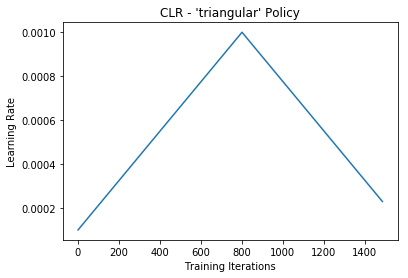

In [32]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr.history['iterations'], clr.history['lr'])

## Cyclic LR - Mode: triangular2

In [0]:
clr_tri2 = CyclicLR(base_lr=0.001, max_lr=0.1,
                                step_size=300., mode='triangular2')

In [0]:
clr_callback_list = [clr_tri2]

In [39]:
batch_size = 1024

H = model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size,
    callbacks = clr_callback_list,
    #initial_epoch=50
)

Epoch 1/15
97/97 [==============================] - 66s 683ms/step - loss: 6.8039 - acc: 0.0051 - val_loss: 6.8449 - val_acc: 0.0065
Epoch 2/15
97/97 [==============================] - 63s 651ms/step - loss: 6.9109 - acc: 0.0058 - val_loss: 7.4983 - val_acc: 0.0034
Epoch 3/15
97/97 [==============================] - 63s 648ms/step - loss: 7.7729 - acc: 0.0047 - val_loss: 8.8059 - val_acc: 0.0035
Epoch 4/15
97/97 [==============================] - 63s 649ms/step - loss: 6.2205 - acc: 0.0043 - val_loss: 6.2280 - val_acc: 0.0069
Epoch 5/15
97/97 [==============================] - 63s 653ms/step - loss: 6.0527 - acc: 0.0050 - val_loss: 6.0075 - val_acc: 0.0043
Epoch 6/15
97/97 [==============================] - 63s 654ms/step - loss: 6.0029 - acc: 0.0039 - val_loss: 6.0086 - val_acc: 0.0035
Epoch 7/15
97/97 [==============================] - 63s 650ms/step - loss: 5.9934 - acc: 0.0047 - val_loss: 5.9953 - val_acc: 0.0029
Epoch 8/15
97/97 [==============================] - 63s 654ms/step - 

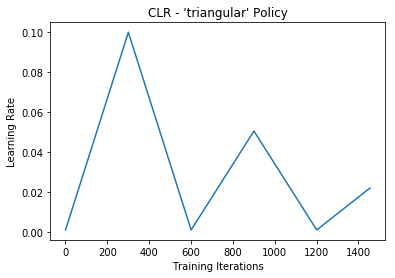

In [42]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - 'triangular' Policy")
plt.plot(clr_tri2.history['iterations'], clr_tri2.history['lr'])

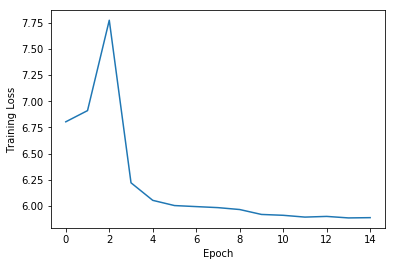

In [46]:
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.plot(H.epoch, H.history['loss'])

## CLR - Exponentation

In [0]:
clr_exp = CyclicLR(base_lr=0.001, max_lr=0.1,
                                step_size=300., mode='exp_range')

In [0]:
clr_callback_list = [clr_exp]

In [49]:
batch_size = 1024

H_exp = model.fit_generator(
    train_generator,
    steps_per_epoch=num_train_samples // batch_size,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=num_validation_samples // batch_size,
    callbacks = clr_callback_list,
    #initial_epoch=50
)

Epoch 1/15
97/97 [==============================] - 64s 662ms/step - loss: 5.8868 - acc: 0.0039 - val_loss: 5.8550 - val_acc: 0.0039
Epoch 2/15
97/97 [==============================] - 63s 648ms/step - loss: 5.8747 - acc: 0.0043 - val_loss: 5.9173 - val_acc: 0.0048
Epoch 3/15
97/97 [==============================] - 63s 648ms/step - loss: 5.8379 - acc: 0.0041 - val_loss: 5.8098 - val_acc: 0.0026
Epoch 4/15
97/97 [==============================] - 62s 644ms/step - loss: 5.8200 - acc: 0.0038 - val_loss: 5.7802 - val_acc: 0.0029
Epoch 5/15
97/97 [==============================] - 63s 647ms/step - loss: 5.7902 - acc: 0.0042 - val_loss: 5.8154 - val_acc: 0.0039
Epoch 6/15
97/97 [==============================] - 63s 646ms/step - loss: 5.8368 - acc: 0.0041 - val_loss: 5.7722 - val_acc: 0.0022
Epoch 7/15
97/97 [==============================] - 63s 645ms/step - loss: 5.8031 - acc: 0.0039 - val_loss: 5.8148 - val_acc: 0.0043
Epoch 8/15
97/97 [==============================] - 62s 637ms/step - 

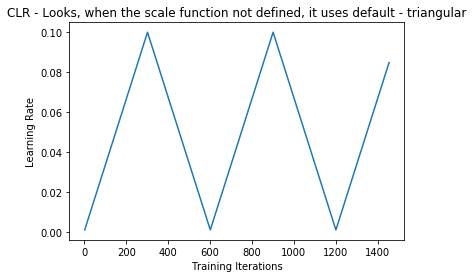

In [52]:
plt.xlabel('Training Iterations')
plt.ylabel('Learning Rate')
plt.title("CLR - Looks, when the scale function not defined, it uses default - triangular")
plt.plot(clr_exp.history['iterations'], clr_exp.history['lr'])